# Results: external forcing runs

In [1]:
from functools import partial
from operator import itemgetter

import iris
import matplotlib.colors as mcol
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
from iris.experimental import stratify
from matplotlib.offsetbox import AnchoredText

In [2]:
from tqdm.notebook import tqdm

In [20]:
import aeolus
from aeolus.calc import sigma_p, spatial_mean, time_mean, zonal_mean
from aeolus.const import init_const
from aeolus.coord import (
    get_cube_rel_days,
    get_xy_coords,
    interp_cube_from_height_to_pressure_levels,
    interp_cubelist_from_height_to_pressure_levels,
    isel,
    regrid_3d,
    replace_z_coord,
    roll_cube_pm180,
)
from aeolus.core import AtmoSim
from aeolus.io import create_dummy_cube, load_vert_lev
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator, tex2cf_units
from aeolus.subset import extract_last_n_days, unique_cubes

In [4]:
import pouch
from pouch.clim_diag import calc_derived_cubes, last_n_day_mean
from pouch.plot import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_SYM0,
    KW_ZERO_LINE,
    figsave,
    linspace_pm1,
    use_style,
)

KW_SYM0 = {**KW_SYM0, "cmap": "seismic"}

import paths
import quickplot as qplt

In [5]:
def make_list_2d(list_x, list_y):
    return [[f"{key_y}-{key_x}" for key_x in list_x] for key_y in list_y]

In [6]:
plt.style.use("custom.mplstyle")
# plt.style.use("seaborn-v0_8-darkgrid")
pouch.RUNTIME.figsave_stamp = False

In [7]:
%load_ext watermark

%watermark
%watermark -iv

Last updated: 2022-11-20T12:31:18.275553+00:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.6.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 4.15.0-194-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 192
Architecture: 64bit

iris      : 3.3.1
pouch     : 0.0.dev0
aeolus    : 0.4.15+14.g02f78ce
numpy     : 1.23.5
matplotlib: 3.6.2



In [8]:
def load_raw_um_data(sim_label, subdir=""):
    fnames = sorted((paths.results_raw_um / sim_label / subdir).glob("atmos*/*a.p*"))
    return iris.load(fnames)


def load_proc_um_data(sim_label):
    fnames = sorted((paths.results_proc_um / sim_label).glob(f"{sim_label}*.nc"))
    with iris.FUTURE.context(datum_support=True):
        dset = iris.load(fnames)
    return dset


def load_proc_lfric_data(sim_label):
    fnames = sorted((paths.results_proc_lfric / sim_label).glob(f"{sim_label}*.nc"))
    with iris.FUTURE.context(datum_support=True):
        dset = iris.load(fnames)
    return dset

In [9]:
from aeolus.model.base import Model

In [10]:
lfric = Model(
    # Coordinates
    t="time",
    z="level_height",
    lev="full_levels",
    p="air_pressure",
    y="latitude",
    x="longitude",
    # Variables
    u="eastward_wind",
    v="northward_wind",
    w="upward_air_velocity",
    pres="air_pressure",
    thta="air_potential_temperature",
    exner="exner_pressure",
    temp="air_temperature",
    dens="air_density",
    p_sfc="surface_air_pressure",
)

In [11]:
SIM_CASES = {
    # "hs": {
    #     "title": "Held-Suarez Idealised Planet",
    #     "short_title": "HS-IP",
    #     "planet": "earth",
    #     "kw_plt": {"color": "C0"},
    #     "timestep": 1200,
    # },
    "el": {
        "title": "Earth-like",
        "short_title": "EL",
        "planet": "earth",
        "kw_plt": {"color": "C1"},
        "timestep": 1200,
    },
    # "tle": {
    #     "title": "Tidally Locked Earth",
    #     "short_title": "TLE",
    #     "planet": "earth",
    #     "kw_plt": {"color": "C2"},
    #     "timestep": 1200,
    # },
    # "hs2": {
    #     "title": "Held-Suarez Dynamical Core",
    #     "short_title": "HS-DC",
    #     "planet": "earth",
    #     "kw_plt": {"color": "C3"},
    #     "timestep": 1200,
    # },
}

MODELS = {
    "um": {
        "model": um,
        "title": "UM",
        "get_files": load_proc_um_data,
        "kw_plt": {"linestyle": "--", "linewidth": 0.75, "dash_capstyle": "round"},
    },
    "lfric": {
        "model": lfric,
        "title": "LFRic",
        "get_files": load_proc_lfric_data,
        "kw_plt": {"linestyle": "-", "linewidth": 1.25},
    },
}

In [12]:
# height_theta, height_rho = the_run.extract("height_above_reference_ellipsoid")
height_theta = np.linspace(0, 32000, 33)
height_rho = np.linspace(1000, 32000, 32) - 500

In [13]:
runs = {}
for model_key, model_prop in MODELS.items():
    model = model_prop["model"]
    runs[model_key] = {}
    # if model_key == "lfric":
    #     continue

    for sim_label, sim_prop in SIM_CASES.items():
        cl = model_prop["get_files"](sim_label)
        cl
        const = init_const(sim_prop["planet"])
        calc_derived_cubes(cl, const=const, model=model)
        if model_key == "lfric":
            kappa = const.dry_air_gas_constant / const.dry_air_spec_heat_press
            pres = (
                cl.extract_cube(model.exner) ** (1 / kappa.data)
            ) * const.reference_surface_pressure
            pres.rename("air_pressure")
            cl.append(pres)
            # Temporary hack
            p_sfc = pres.extract(iris.Constraint(**{model.z: 0}))
            p_sfc.rename(model.p_sfc)
            cl.append(p_sfc)
        runs[model_key][sim_label] = AtmoSim(
            cl,
            name=sim_label,
            vert_coord="z",
            planet=sim_prop["planet"],
            const_dir=paths.const,
            model=model,
        )
        np.testing.assert_allclose(
            height_theta, runs[model_key][sim_label].coord.z.points
        )

## Interpolate to sigma levels

Create a callable to pass to the interpolation routine. Use linear extrapolation.

In [14]:
INTERPOLATOR = partial(
    stratify.stratify.interpolate,
    interpolation=stratify.stratify.INTERPOLATE_LINEAR,
    extrapolation=stratify.stratify.EXTRAPOLATE_LINEAR,
)

Create an array of $\sigma_p=p/p_s$ levels, close to the table A1 in Mayne et al. (2014).

In [15]:
sigma_levels = np.linspace(1, 0.01, 34)

Interpolate all 3D cubes to the $\sigma_p$ levels.

In [55]:
runs_sigma_p = {}
for model_key, model_prop in MODELS.items():
    model = model_prop["model"]
    runs_sigma_p[model_key] = {}
    # if model_key == "lfric":
    #     continue

    for sim_label, sim_prop in SIM_CASES.items():
        runs_sigma_p[model_key][sim_label] = iris.cube.CubeList()
        for cube_name in ["pres", "temp", "thta", "u", "v", "w"]:
            runs_sigma_p[model_key][sim_label].append(
                stratify.relevel(
                    runs[model_key][sim_label][cube_name],
                    runs[model_key][sim_label].sigma_p,
                    sigma_levels,
                    axis=um.z,
                    interpolator=INTERPOLATOR,
                )
            )

In [56]:
# lons, lats = get_xy_coords(runs_sigma_p[model_key][sim_label][0], model=um)
# lons, lats = lons.points, lats.points

## Zonal mean cross-sections

In [57]:
DIAGS = {
    "temp": {
        "recipe": lambda cl, model=um: zonal_mean(
            last_n_day_mean(cl.extract_cube(model.temp), 1000)
        ),
        "title": "Air Temperature",
        "tex_units": "$K$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "plasma", "levels": np.arange(190, 321, 10), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(200, 400, 10),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
    "u": {
        "recipe": lambda cl, model=um: zonal_mean(
            last_n_day_mean(cl.extract_cube(model.u), 1000)
        ),
        "title": "Eastward Wind",
        "tex_units": "$m$ $s^{-1}$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "RdBu_r", "levels": np.arange(-36, 37, 4), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(-200, 200, 4),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
}

### Plot all cases

/home/ds591/mambaforge/envs/lfric_ana/lib/python3.10/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))
/home/ds591/mambaforge/envs/lfric_ana/lib/python3.10/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


Saved to ../figures/exf__um_lfric__el__zm__temp_u.png


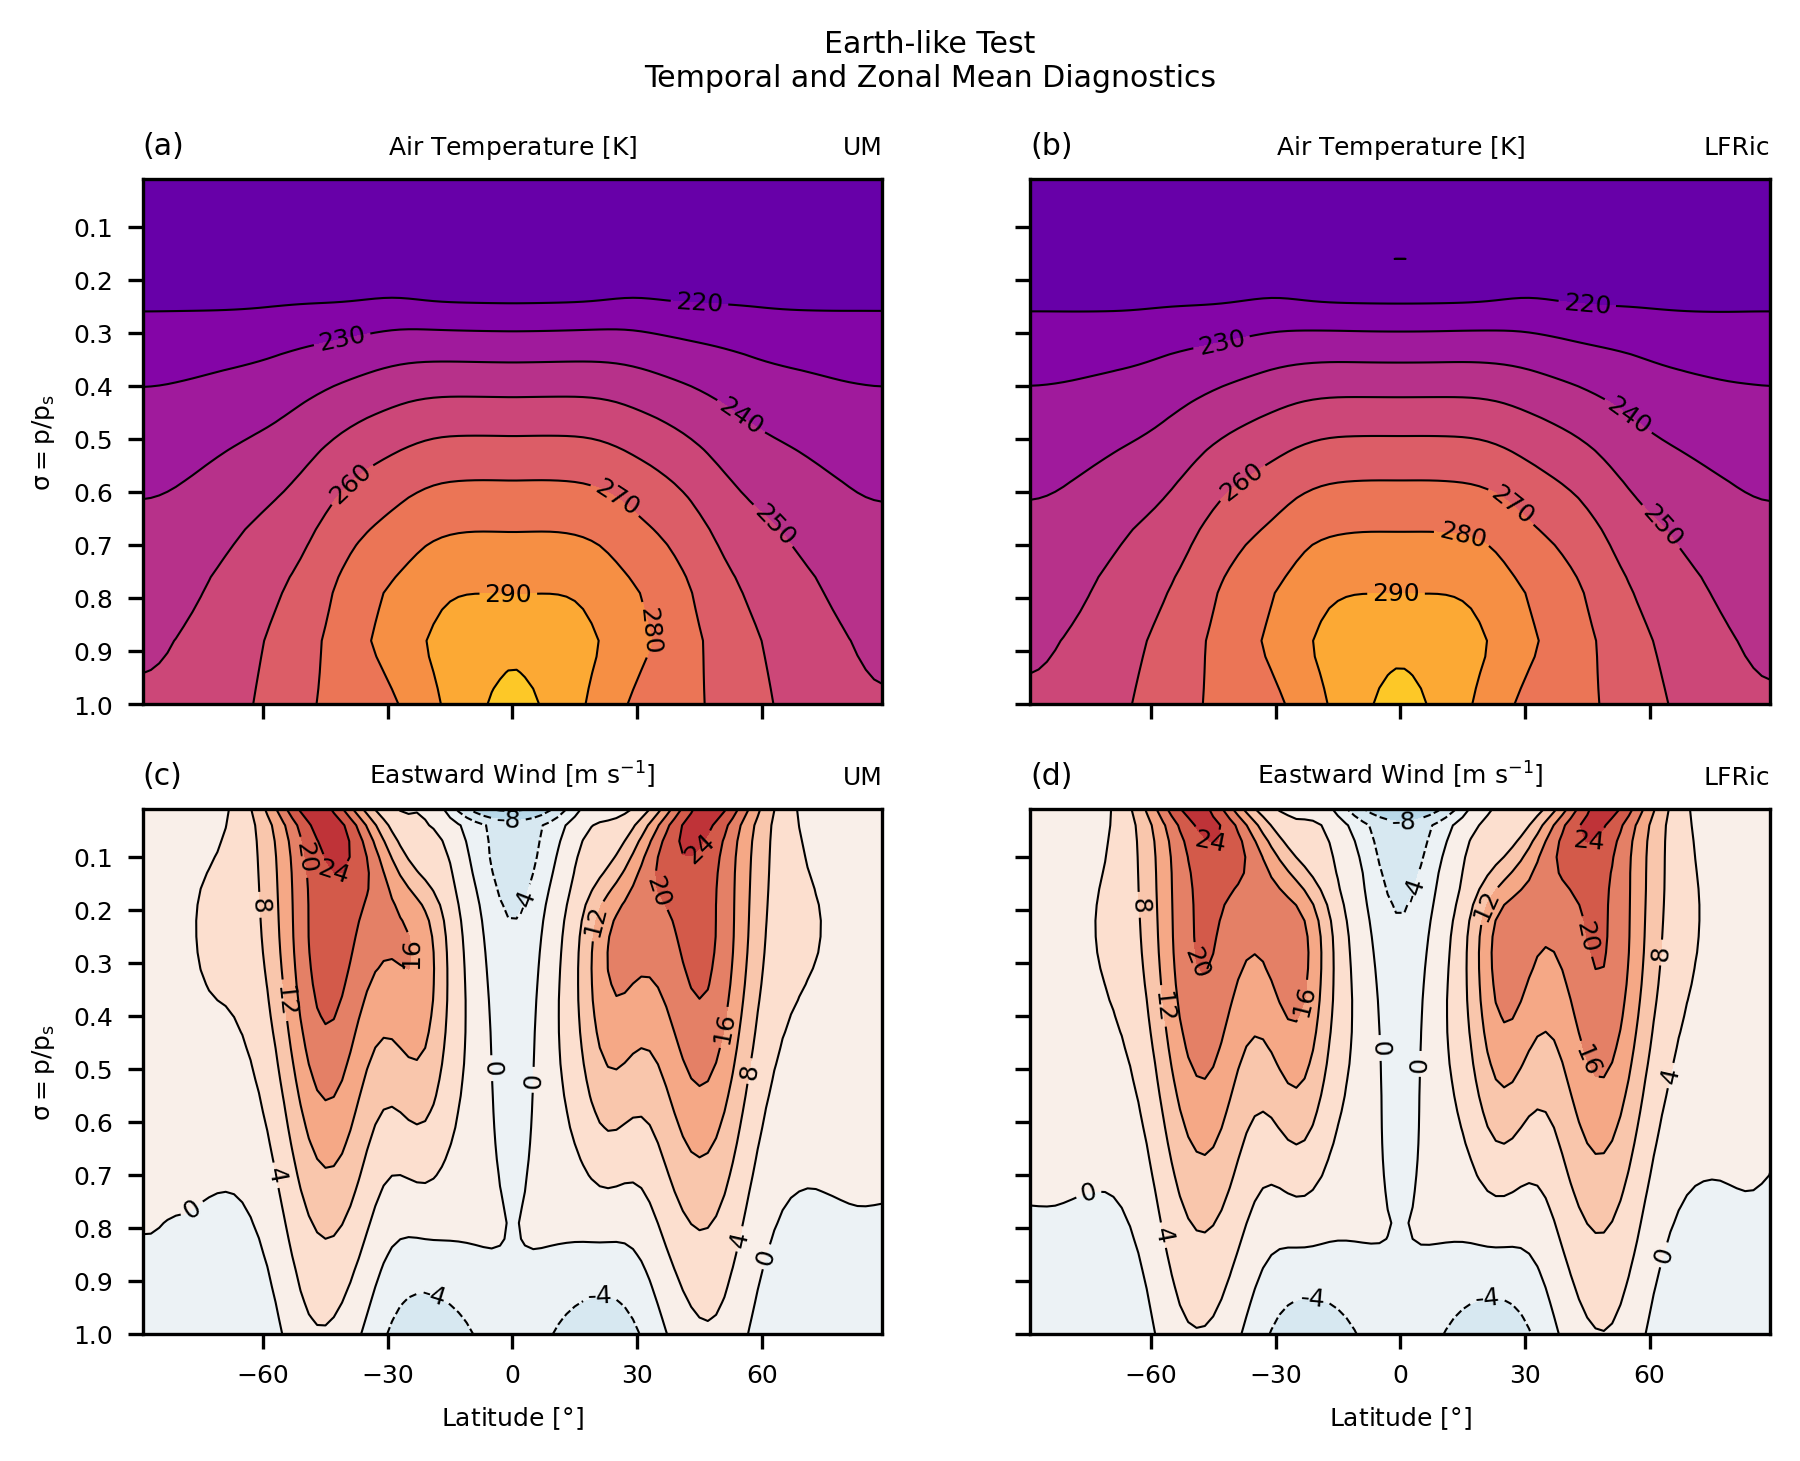

In [60]:
for sim_label in ["el"]:
    sim_prop = SIM_CASES[sim_label]

    fig = plt.figure(figsize=(7, 5))
    fig.suptitle(f"{sim_prop['title']} Test\nTemporal and Zonal Mean Diagnostics")
    axd = fig.subplot_mosaic(
        make_list_2d(MODELS.keys(), DIAGS.keys()),
        gridspec_kw={"wspace": 0.2},
        sharex=True,
        sharey=True,
    )
    iletters = subplot_label_generator()
    for ax in axd.values():
        ax.set_title(f"({next(iletters)})", loc="left")
        ax.set_xticks(np.arange(-90, 91, 30))
        ax.set_yticks(np.arange(1.0, 0.0, -0.1))
        ax.set_ylim(itemgetter(0, -1)(sigma_levels))
        ax.set_xlim(-89, 89)

        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Latitude [$\degree$]")
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("$\sigma=p/p_s$")

    for model_key, model_prop in MODELS.items():
        model = model_prop["model"]
        for diag_key, diag_prop in DIAGS.items():
            ax = axd[f"{diag_key}-{model_key}"]
            tex_units = diag_prop["tex_units"]
            ttl = diag_prop["title"]
            if tex_units != "1":
                ttl += f" [{tex_units}]"
            ax.set_title(ttl, size="medium", loc="center")
            ax.set_title(model_prop["title"], size="medium", loc="right")
            # if model_key == "lfric":
            #     ax.text(0.5, 0.5, "Coming Soon...", va="center", ha="center")
            #     continue

            cube = diag_prop["recipe"](runs_sigma_p[model_key][sim_label], model=model)
            cube.convert_units(tex2cf_units(diag_prop["tex_units"]))
            x = cube.coord(um.y).points
            y = cube.coord("atmosphere_hybrid_sigma_pressure_coordinate").points
            z = cube.data

            plt_items = itemgetter("plt_method", "kw_plt", "add_colorbar", "add_clabel")
            for plt_method, kw_plt, add_colorbar, add_clabel in zip(
                *plt_items(diag_prop)
            ):
                pic = getattr(ax, plt_method)(x, y, z, **kw_plt)
                if add_colorbar:
                    fig.colorbar(pic, ax=ax)
                if add_clabel:
                    ax.clabel(pic, fmt="%.0f", use_clabeltext=True)
    figsave(
        fig,
        paths.figures
        / f"exf__{'_'.join(MODELS.keys())}__{sim_label}__zm__{'_'.join(DIAGS.keys())}",
    )

## Maps

In [23]:
DIAGS = {
    "temp": {
        "recipe": lambda cl: zonal_mean(
            last_n_day_mean(cl.extract_cube(um.temp), 1000)
        ),
        "title": "Air Temperature",
        "tex_units": "$K$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "plasma", "levels": np.arange(190, 321, 10), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(200, 400, 10),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
    "u": {
        "recipe": lambda cl: zonal_mean(last_n_day_mean(cl.extract_cube(um.u), 1000)),
        "title": "Eastward Wind",
        "tex_units": "$m$ $s^{-1}$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "RdBu_r", "levels": np.arange(-36, 37, 4), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(-200, 200, 4),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
}

### Plot all cases

TODO

In [ ]:
for sim_label in [
    "hs",
]:
    sim_prop = SIM_CASES[sim_label]

    fig = plt.figure(figsize=(7, 5))
    fig.suptitle(f"{sim_prop['title']} Test\nTemporal and Zonal Mean Diagnostics")
    axd = fig.subplot_mosaic(
        make_list_2d(MODELS.keys(), DIAGS.keys()),
        gridspec_kw={"wspace": 0.2},
        sharex=True,
        sharey=True,
    )
    iletters = subplot_label_generator()
    for ax in axd.values():
        ax.set_title(f"({next(iletters)})", loc="left")
        ax.set_xticks(np.arange(-90, 91, 30))
        ax.set_yticks(np.arange(1.0, 0.0, -0.1))
        ax.set_ylim(itemgetter(0, -1)(sigma_levels))
        ax.set_xlim(-89, 89)

        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Latitude [$\degree$]")
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("$\sigma=p/p_s$")

    for model_key, model_prop in MODELS.items():
        for diag_key, diag_prop in DIAGS.items():
            ax = axd[f"{diag_key}-{model_key}"]
            tex_units = diag_prop["tex_units"]
            ttl = diag_prop["title"]
            if tex_units != "1":
                ttl += f" [{tex_units}]"
            ax.set_title(ttl, size="medium", loc="center")
            ax.set_title(model_prop["title"], size="medium", loc="right")
            if model_key == "lfric":
                ax.text(0.5, 0.5, "Coming Soon...", va="center", ha="center")
                continue

            cube = diag_prop["recipe"](runs_sigma_p[model_key][sim_label])
            cube.convert_units(tex2cf_units(diag_prop["tex_units"]))
            x = cube.coord(um.y).points
            y = cube.coord("atmosphere_hybrid_sigma_pressure_coordinate").points
            z = cube.data

            plt_items = itemgetter("plt_method", "kw_plt", "add_colorbar", "add_clabel")
            for plt_method, kw_plt, add_colorbar, add_clabel in zip(
                *plt_items(diag_prop)
            ):
                pic = getattr(ax, plt_method)(x, y, z, **kw_plt)
                if add_colorbar:
                    fig.colorbar(pic, ax=ax)
                if add_clabel:
                    ax.clabel(pic, fmt="%.0f", use_clabeltext=True)
    figsave(
        fig,
        paths.figures
        / f"exf__{'_'.join(MODELS.keys())}__{sim_label}__lev{ilev:02d}__{'_'.join(DIAGS.keys())}",
    )

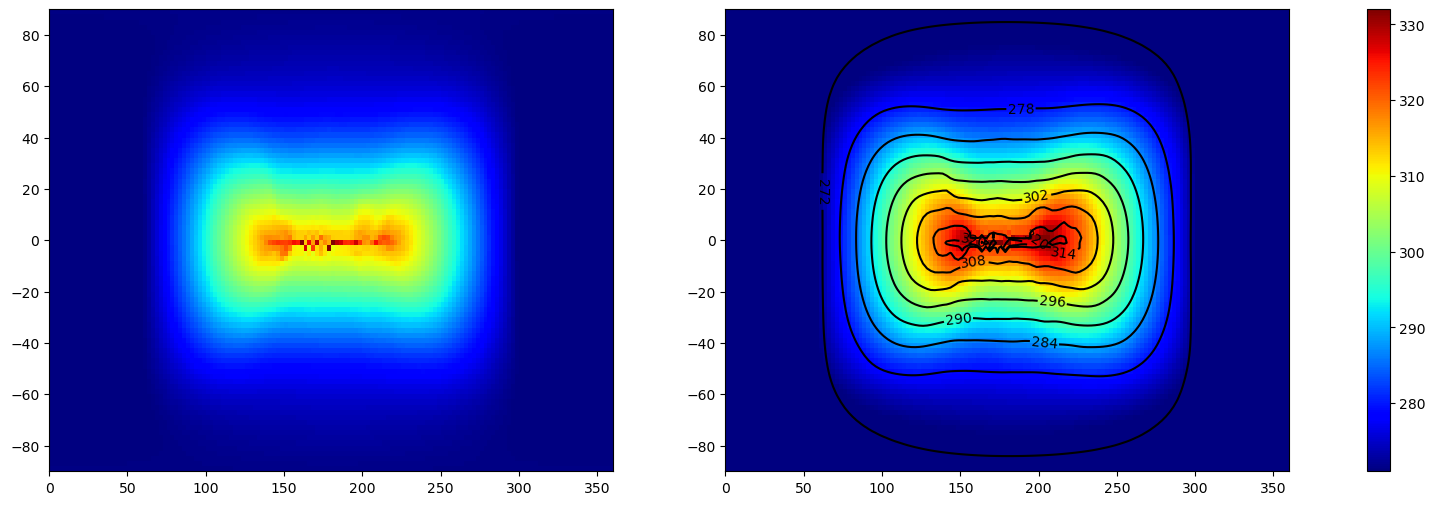

In [24]:
fig, axs = plt.subplots(figsize=(20, 6), ncols=2)
pcol0 = axs[0].pcolormesh(
    lons, lats, theta[0, 0, ...].data, vmin=271, vmax=332, cmap=plt.cm.jet
)
pcol1 = axs[1].pcolormesh(
    lons, lats, theta[-1, 0, ...].data, vmin=271, vmax=332, cmap=plt.cm.jet
)
cntr = axs[1].contour(
    lons, lats, theta[0, 0, ...].data, colors="k", levels=np.arange(272, 321, 6)
)
axs[1].clabel(cntr, fmt="%.0f")

fig.colorbar(pcol0, ax=axs)

## Time series

In [11]:
DIAGS = {
    "temp_lev00": {
        "recipe": lambda AS: spatial_mean(isel(AS.temp, um.z, 0)),
        "name": "Air Temperature | Level 0",
        "tex_units": "$K$",
        # "lim": [5, 8],
    },
    "p_sfc": {
        "recipe": lambda AS: spatial_mean(AS.p_sfc),
        "name": "Surface Pressure",
        "tex_units": "$hPa$",
        # "lim": [0, 1.5],
    },
}

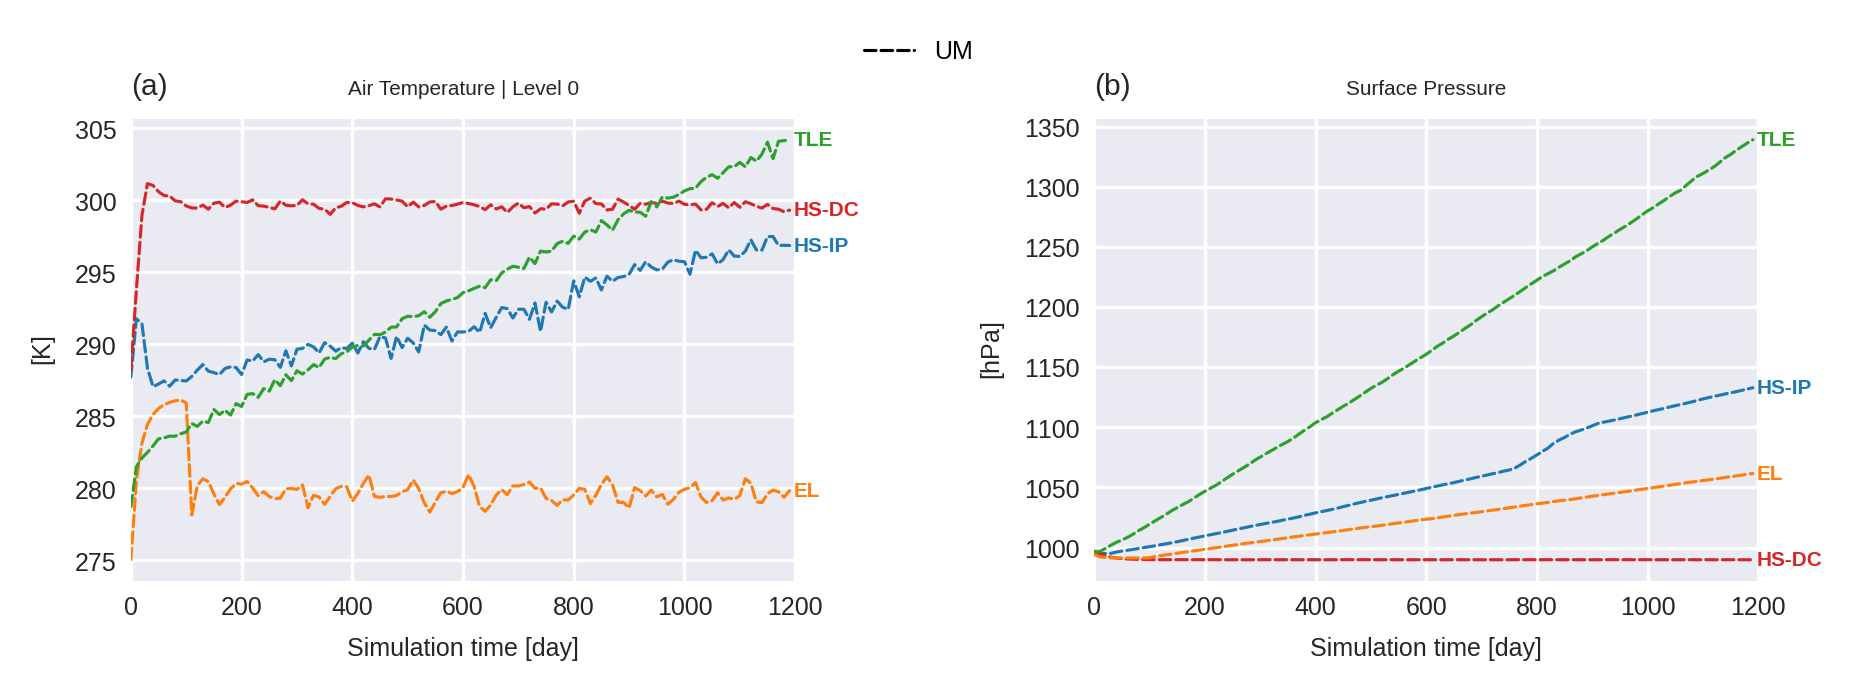

In [12]:
fig = plt.figure(figsize=(7, 2))
axd = fig.subplot_mosaic([DIAGS.keys()], gridspec_kw={"wspace": 0.45}, sharex=True)
iletters = subplot_label_generator()
for ax in axd.values():
    ax.set_title(f"({next(iletters)})", loc="left")

model_key = "um"
model_prop = MODELS[model_key]

for diag_key, diag_prop in DIAGS.items():
    ax = axd[diag_key]
    ax.set_title(diag_prop["name"], size="small")
    # ax.set_ylim(diag_prop.get("lim"))
    ax.set_ylabel(f"[{diag_prop['tex_units']}]")
    ax.set_xlim(0, 1200)
    ax.set_xticks(np.arange(0, 1201, 200), dtype=int)
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Simulation time [day]")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    for sim_label, sim_prop in SIM_CASES.items():
        cube = diag_prop["recipe"](runs[model_key][sim_label])
        cube.convert_units(tex2cf_units(diag_prop["tex_units"]))
        days = get_cube_rel_days(cube)
        x = days
        y = cube.data
        ax.plot(x, y, **sim_prop["kw_plt"], **model_prop["kw_plt"])
        ax.annotate(
            text=sim_prop["short_title"],
            xy=(x[-1], y[-1]),
            xytext=(1, 0),
            textcoords="offset points",
            va="center",
            color=sim_prop["kw_plt"]["color"],
            fontsize="small",
            weight="bold",
        )
add_custom_legend(
    fig,
    {v["title"]: {"color": "k", **v["kw_plt"]} for v in MODELS.values()},
    ncol=len(MODELS),
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
)
# figsave(
#     fig,
#     paths.figures
#     / f"exf_{'_'.join(MODELS.keys())}_{'_'.join(SIM_CASES.keys())}_{'_'.join(DIAGS.keys())}",
# )